__Author:__ Bram Van de Sande

__Date:__ 29 APR 2019

__Outline:__ Notebook demonstrating SCENIC integration with scanpy.

In [20]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
from cytoolz import compose
import operator as op

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell

In [3]:
# Set maximum number of jobs
sc.settings.njobs = 32

# GSE115978 - Cutaneous Melanoma (SKCM)

_Publication:_

Livnat Jerby-Arnon et al., A Cancer Cell Program Promotes T Cell Exclusion and Resistance to Checkpoint Blockade., Cell 2018, https://dx.doi.org/10.1016/j.cell.2018.09.006

_Data set acquisition:_

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115978

_Remarks:_
1. This data set includes samples from previous study (Itay Tirosh et al.).
2. Codes:

| Code | Description |
| ---- | ----------- |
| OR | Objective Response |
| ICI | Immune Checkpoint Inhibitor |

In [6]:
BASE_FOLDER = "/Users/bramvandesande/Projects/lcb/resources/"

# Downloaded from GEO on 29 APR 2019.
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE115978&format=file&file=GSE115978%5Fcell%2Eannotations%2Ecsv%2Egz
CELL_ANNOTATIONS_FNAME = os.path.join(BASE_FOLDER, "GSE115978_cell.annotations.csv")

# Downloaded from Cell Journal website on 1 MAR 2019.
# https://ars-els-cdn-com.kuleuven.ezproxy.kuleuven.be/content/image/1-s2.0-S0092867418311784-mmc1.xlsx
SAMPLE_METADATA_FNAME = os.path.join(BASE_FOLDER, "1-s2.0-S0092867418311784-mmc1.xlsx")

# Downloaded from GEO on 29 APR 2019.
# https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE115978&format=file&file=GSE115978%5Ftpm%2Ecsv%2Egz
EXP_MTX_TPM_FNAME = os.path.join(BASE_FOLDER, 'GSE115978_tpm.csv')

EXP_MTX_QC_TPM_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.qc.tpm.csv')
METADATA_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.metadata.csv')
ANNDATA_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.h5ad')

AUCELL_MTX_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.auc.csv')
REGULONS_DAT_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.regulons.dat')
LOOM_FNAME = os.path.join(BASE_FOLDER, 'GSE115978.loom')

__METADATA CLEANING__

In [7]:
df_annotations = pd.read_csv(CELL_ANNOTATIONS_FNAME)
df_annotations['samples'] = df_annotations['samples'].str.upper()
df_annotations.rename(columns={'cell.types': 'cell_type', 'cells': 'cell_id', 'samples': 'sample_id', 
                               'treatment.group': 'treatment_group', 'Cohort': 'cohort'}, inplace=True)
df_annotations['cell_type'] = df_annotations.cell_type.replace({
    'Mal': 'Malignant Cell',
    'Endo.': 'Endothelial Cell',
    'T.CD4': 'Thelper Cell',
    'CAF': 'Fibroblast',
    'T.CD8': 'Tcytotoxic Cell',
    'T.cell': 'T Cell',
    'NK': 'NK Cell',
    'B.cell': 'B Cell'})

In [9]:
df_samples = pd.read_excel(SAMPLE_METADATA_FNAME, header=2)
df_samples = df_samples.drop(['Cohort'], axis=1)
df_samples['Sample'] = df_samples.Sample.str.upper()

In [10]:
df_metadata = pd.merge(df_annotations, df_samples, left_on='sample_id', right_on='Sample')
df_metadata = df_metadata.drop(['Sample', 'treatment_group'], axis=1)
df_metadata.rename(columns={'Patient': 'patient_id',
                           'Age': 'age', 'Sex': 'sex', 'Lesion type': 'lesion_type', 'Site': 'site',
                           'Treatment': 'treatment', 'Treatment group': 'treatment_group'}, inplace=True)

In [11]:
df_metadata.head()

cell_id sample_id       cell_type  cohort  \
0  cy78_CD45_neg_1_B04_S496_comb     MEL78  Malignant Cell  Tirosh   
1  cy78_CD45_neg_3_H06_S762_comb     MEL78  Malignant Cell  Tirosh   
2  cy78_CD45_neg_1_D07_S523_comb     MEL78  Malignant Cell  Tirosh   
3  cy78_CD45_neg_3_D01_S709_comb     MEL78  Malignant Cell  Tirosh   
4  cy78_CD45_neg_2_B08_S596_comb     MEL78  Malignant Cell  Tirosh   

   no.of.genes  no.of.reads patient_id  age sex  \
0         8258       357919      Mel78   73   M   
1         7409       380341      Mel78   73   M   
2         8548       394632      Mel78   73   M   
3         8472       425938      Mel78   73   M   
4         6475        70466      Mel78   73   M   

                        treatment       treatment_group lesion_type  \
0  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
1  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
2  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
3  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   
4  WDVAX, ipilimumab + nivolumab   Post-ICI (resistant)  metastasis   

           site  
0  Small bowel   
1  Small bowel   
2  Small bowel   
3  Small bowel   
4  Small bowel

In [12]:
df_metadata.to_csv(METADATA_FNAME, index=False)

In [13]:
df_metadata.columns

Index(['cell_id', 'sample_id', 'cell_type', 'cohort', 'no.of.genes',
       'no.of.reads', 'patient_id', 'age', 'sex', 'treatment',
       'treatment_group', 'lesion_type', 'site'],
      dtype='object')

__EXPRESSION MATRIX__

In [14]:
df_tpm = pd.read_csv(EXP_MTX_TPM_FNAME, index_col=0)
df_tpm.shape

(23686, 7186)

__ANNDATA__

In [15]:
df_obs = df_metadata[['cell_id', 'sample_id', 'cell_type', 'cohort', 'patient_id', 'age', 'sex', 'treatment',
                                                           'treatment_group', 'lesion_type', 'site']].set_index('cell_id').sort_index()

In [16]:
adata = sc.AnnData(X=df_tpm.T.sort_index())
adata.obs = df_obs
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata #Store non-log transformed data as raw. This data can be used via the use_raw parameters available for many functions.
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 7186 × 22527 
    obs: 'sample_id', 'cell_type', 'cohort', 'patient_id', 'age', 'sex', 'treatment', 'treatment_group', 'lesion_type', 'site', 'n_genes'
    var: 'n_cells'

In [17]:
adata.write_h5ad(ANNDATA_FNAME)

... storing 'sample_id' as categorical
... storing 'cell_type' as categorical
... storing 'cohort' as categorical
... storing 'patient_id' as categorical
... storing 'sex' as categorical
... storing 'treatment' as categorical
... storing 'treatment_group' as categorical
... storing 'lesion_type' as categorical
... storing 'site' as categorical


To infer GRNs (with SCENIC) the QC'd expression matrix is saved as csv.

In [18]:
adata.to_df().to_csv(EXP_MTX_QC_TPM_FNAME)

__SCENIC: RUN GRN INFERENCE (GRNBOOST2)__

```
pyscenic grn GSE115978.qc.tpm.csv tfs.txt -o GSE115978.adjacencies.tsv --num_workers 4
```

List of TFs (i.e. `tfs.txt`) is downloaded from: Samuel A Lambert, et al. The Human Transcription Factors. Cell 2018 https://dx.doi.org/10.1016/j.cell.2018.01.029

__SCENIC: RUN REGULON PREDICTION (CISTARGET)__

```
pyscenic ctx GSE115978.adjacencies.tsv hg19-500bp-upstream-10species.mc9nr.feather hg19-tss-centered-5kb-10species.mc9nr.feather hg19-tss-centered-10kb-10species.mc9nr.feather --annotations_fname motifs-v9-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname GSE115978.qc.tpm.csv --output GSE115978.motifs.csv --num_workers 26
```

__SCENIC: RUN CELLULAR ENRICHMENT (AUCELL)__

In [19]:
def derive_regulons(code, folder):
    # Load enriched motifs.
    motifs = load_motifs(os.path.join(folder, '{}.motifs.csv'.format(code)))
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('hg19-tss-centered-10kb-10species.mc9nr', 
                                 'hg19-500bp-upstream-10species.mc9nr', 
                                 'hg19-tss-centered-5kb-10species.mc9nr'), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    regulons = list(map(lambda r: r.rename(r.transcription_factor), regulons))

    # Pickle these regulons.
    with open(os.path.join(folder, '{}.regulons.dat'.format(code)), 'wb') as f:
        pickle.dump(regulons, f)

In [ ]:
derive_regulons('GSE115978', BASE_FOLDER)

In [ ]:
with open(REGULONS_DAT_FNAME, 'rb') as f:
    regulons = pickle.load(f)

In [ ]:
auc_mtx = aucell(exp_mtx, regulons, num_workers=20)

In [ ]:
auc_mtx.to_csv(AUCELL_MTX_FNAME)

__ADD DIMENSIONAL REDUCTIONS__

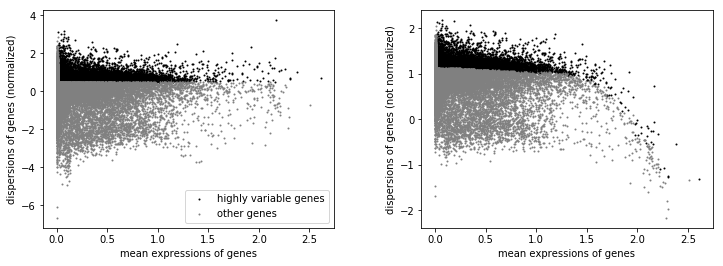

In [19]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [21]:
#adata = adata[:, adata.var['highly_variable']]

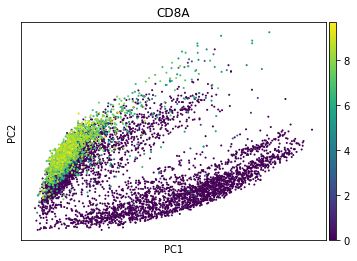

In [22]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CD8A')

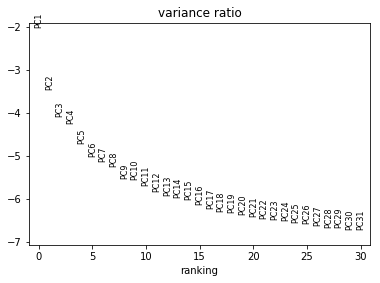

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.tl.louvain(adata)

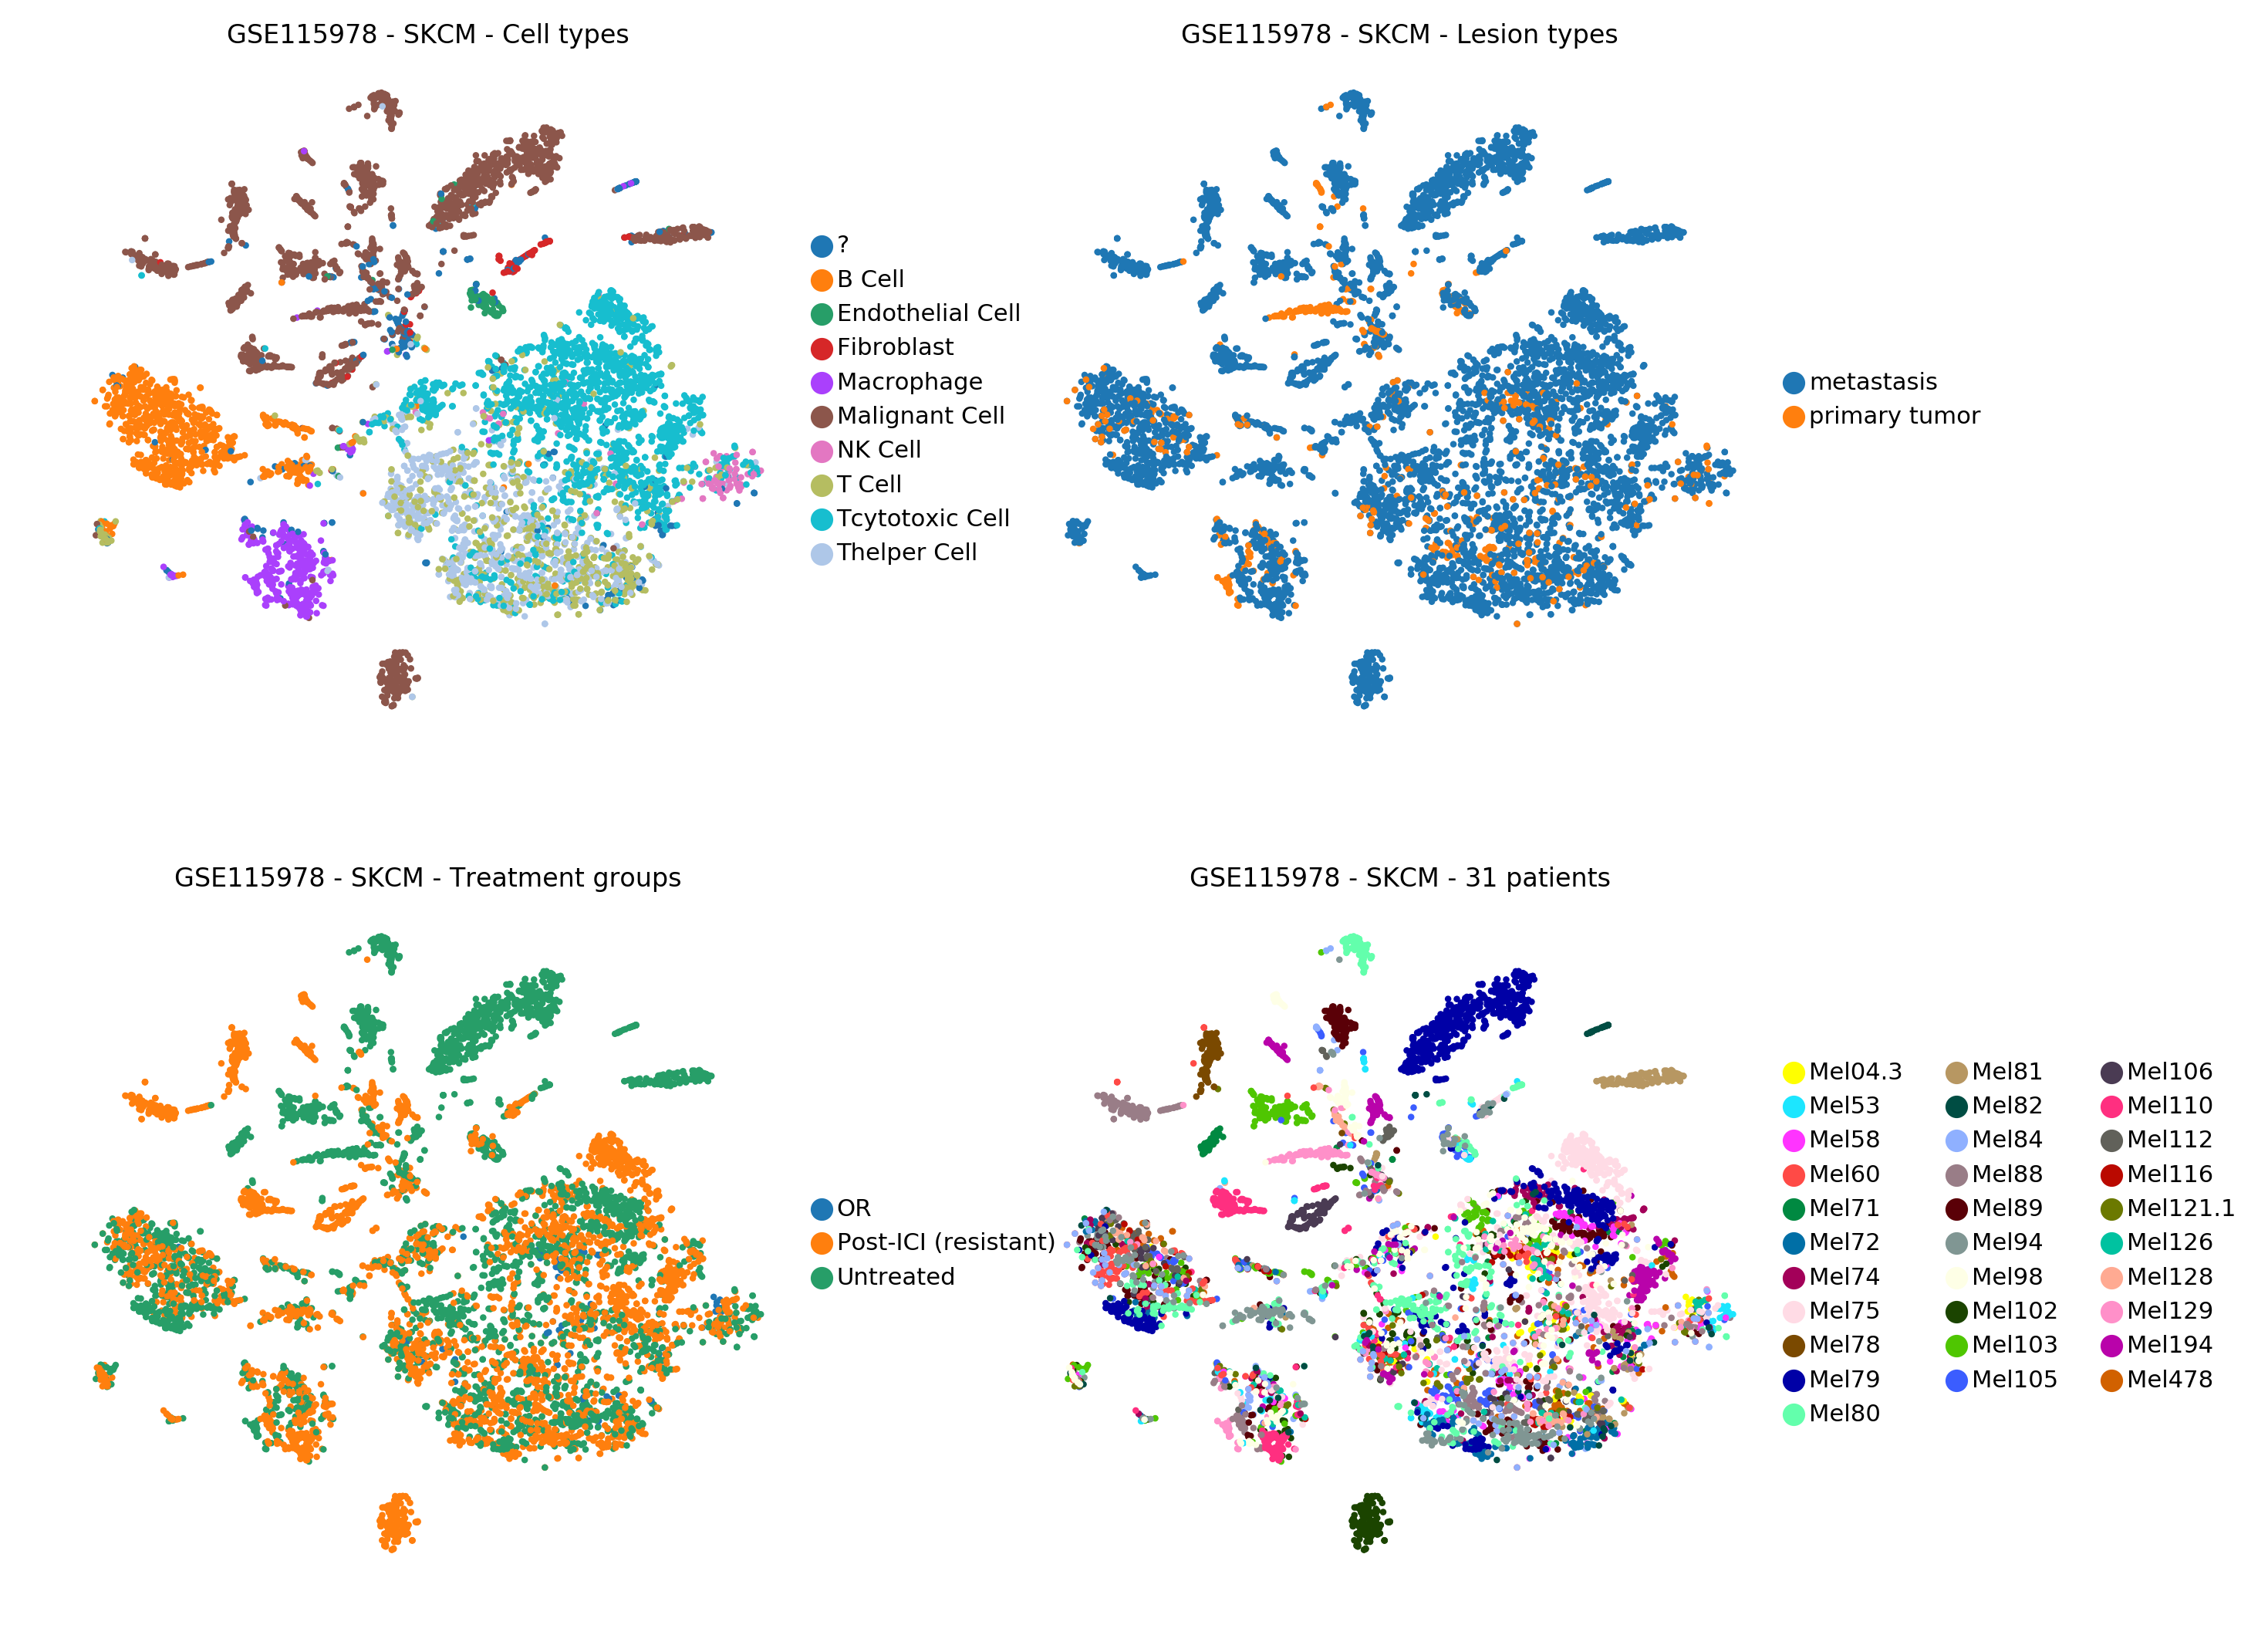

In [25]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'treatment_group', 'patient_id'], 
           title=['GSE115978 - SKCM - Cell types', 'GSE115978 - SKCM - Lesion types', 'GSE115978 - SKCM - Treatment groups',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2)

In [28]:
adata.write_h5ad(ANNDATA_FNAME)

In [ ]:
add_scenic_metadata(adata, auc_mtx, regulons)

In [53]:
adata.var.index[adata.var['Regulon(MITF)']]

Index(['APBB2', 'AEN', 'TOB2', 'SORL1', 'NAT10', 'USP6NL', 'SLC25A46', 'PHF20',
       'GDPD5', 'ABR',
       ...
       'PTK6', 'PSME3', 'UAP1', 'KCNN4', 'MAT2A', 'SEMA4C', 'ARMCX2', 'PEPD',
       'ZNF358', 'SLC39A6'],
      dtype='object', name='index', length=1870)

In [37]:
adata.write_h5ad(ANNDATA_FNAME)

In [ ]:
export2loom(df_tpm.T, regulons, LOOM_FNAME,
                cell_annotations=adata.obs['cell_type'].to_dict(),
                tree_structure=(),
                title='GSE115978',
                nomenclature="HGNC", compress=True)

In [54]:
sc.tl.tsne(adata, use_rep='X_aucell')

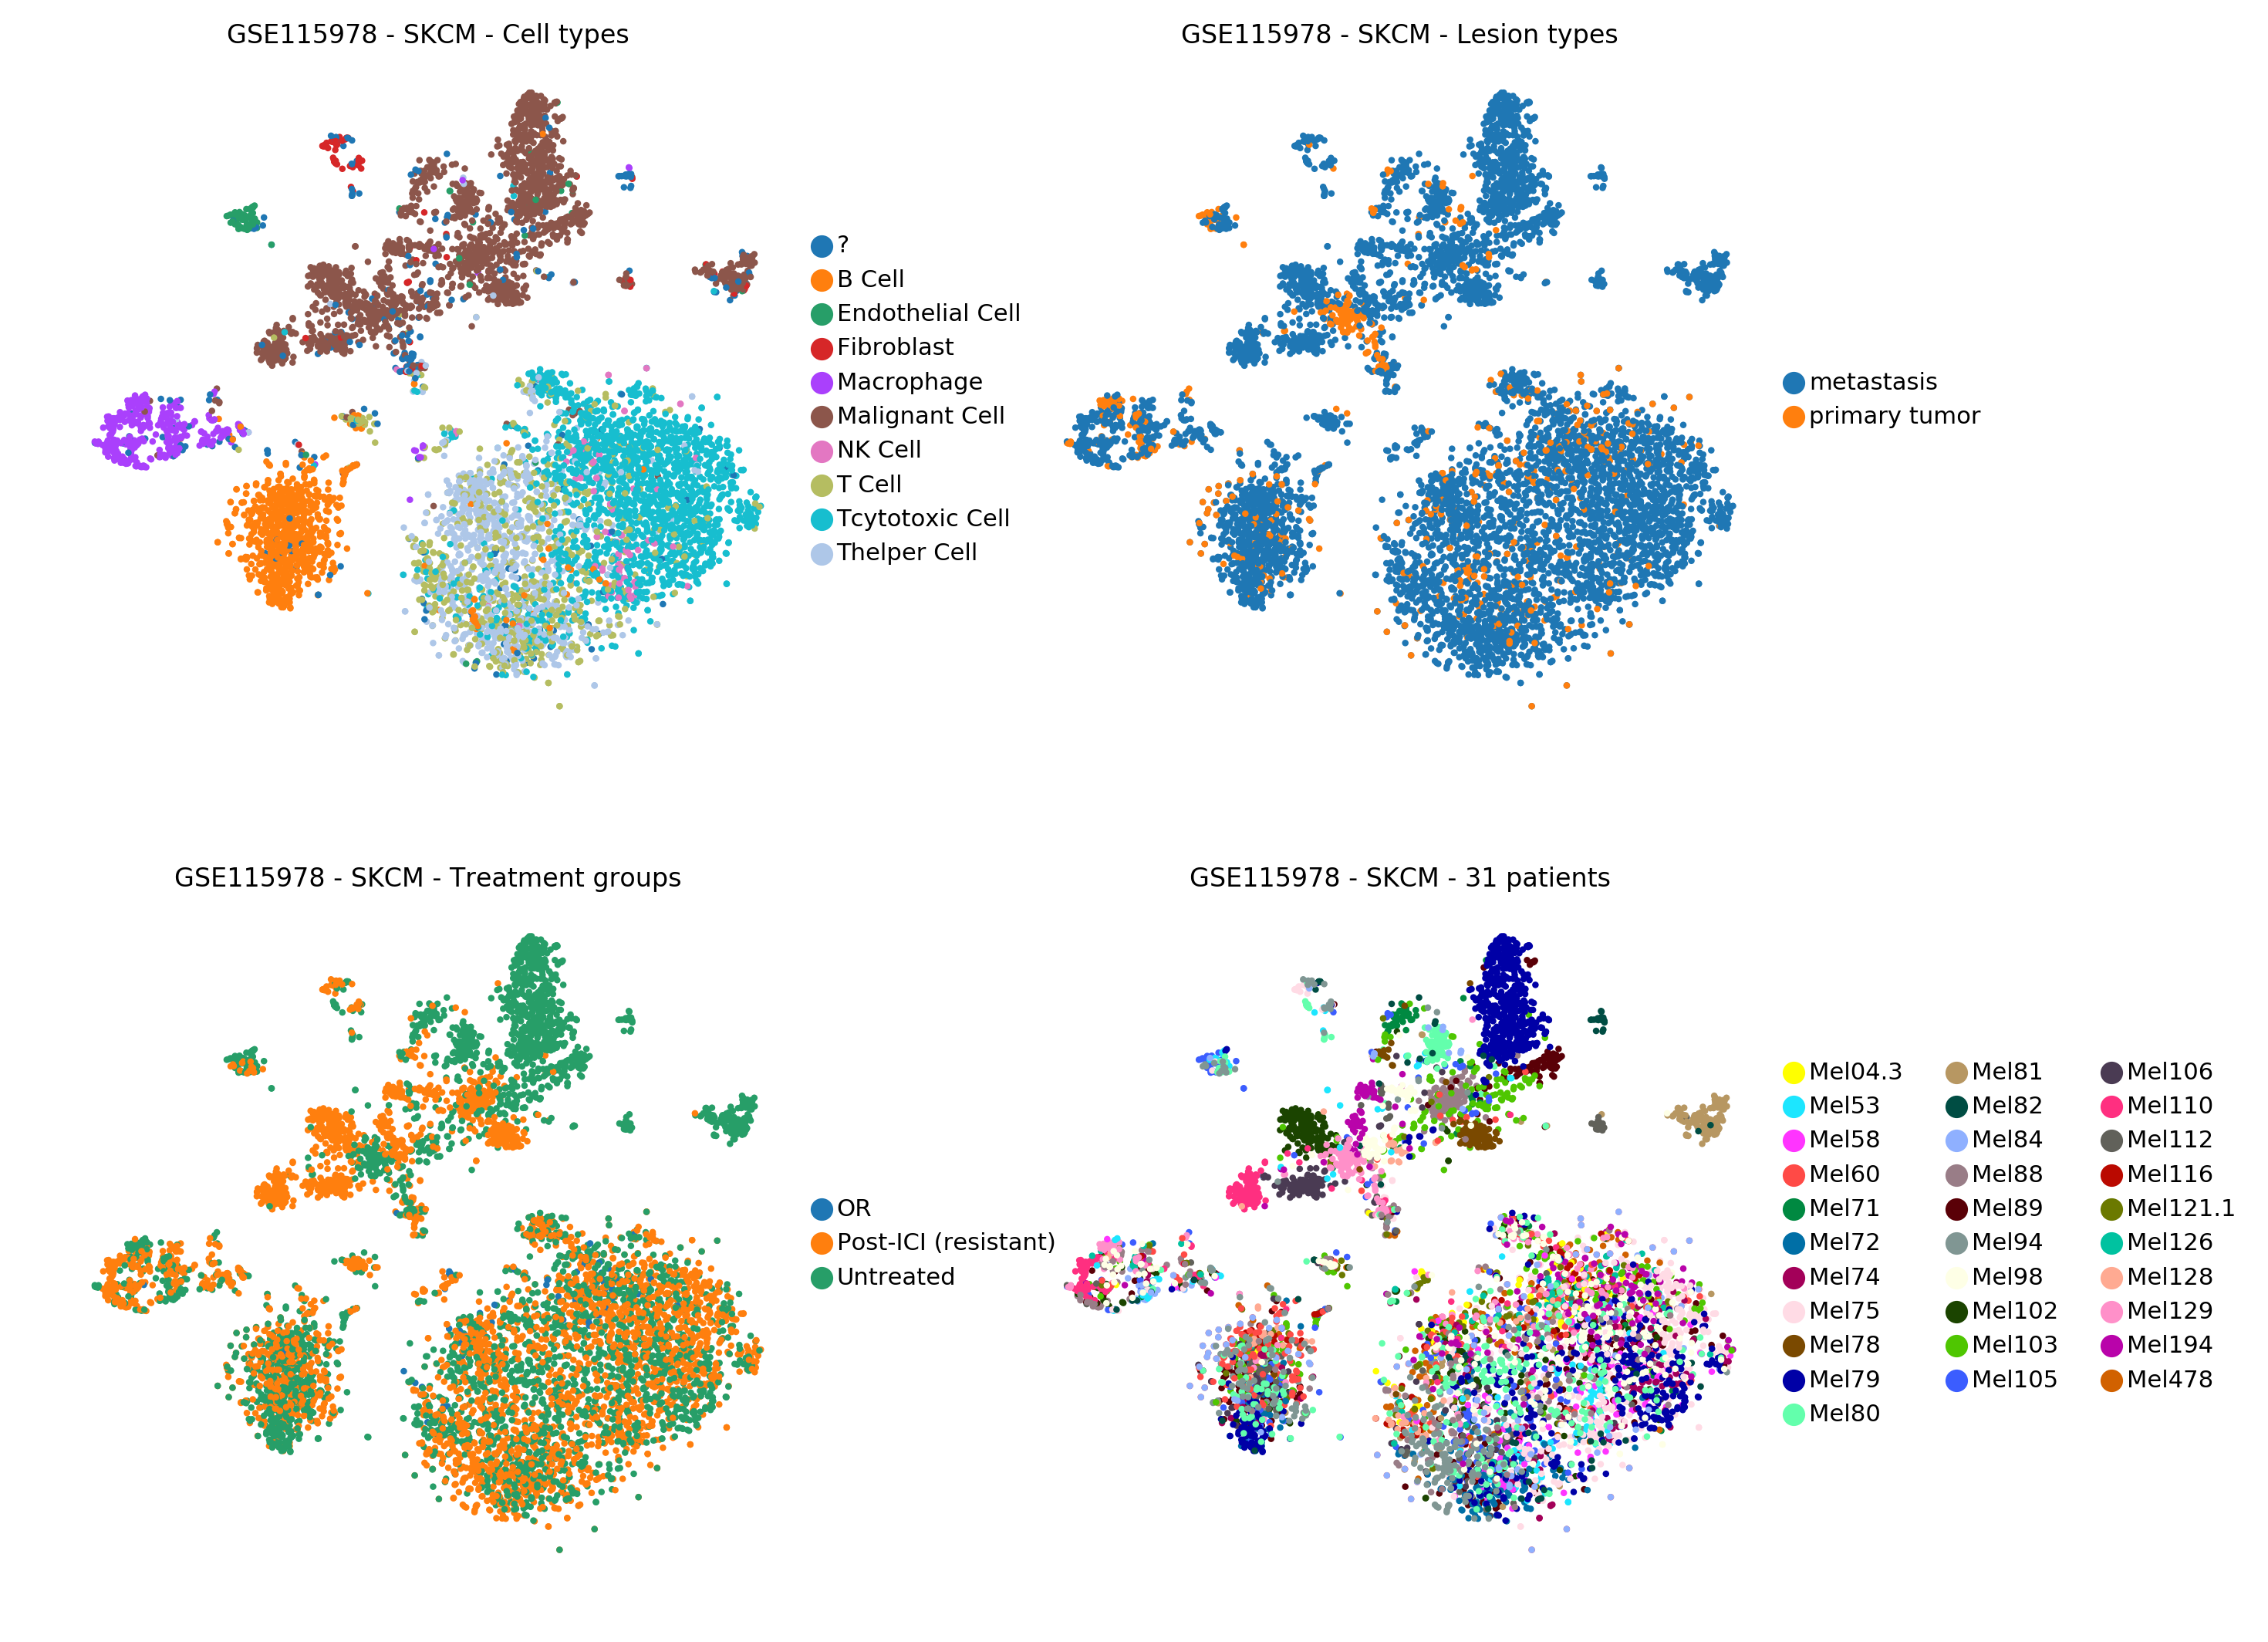

In [55]:
sc.pl.tsne(adata, color=['cell_type', 'lesion_type', 'treatment_group', 'patient_id'], 
           title=['GSE115978 - SKCM - Cell types', 'GSE115978 - SKCM - Lesion types', 'GSE115978 - SKCM - Treatment groups',
                 'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=2, use_raw=False)

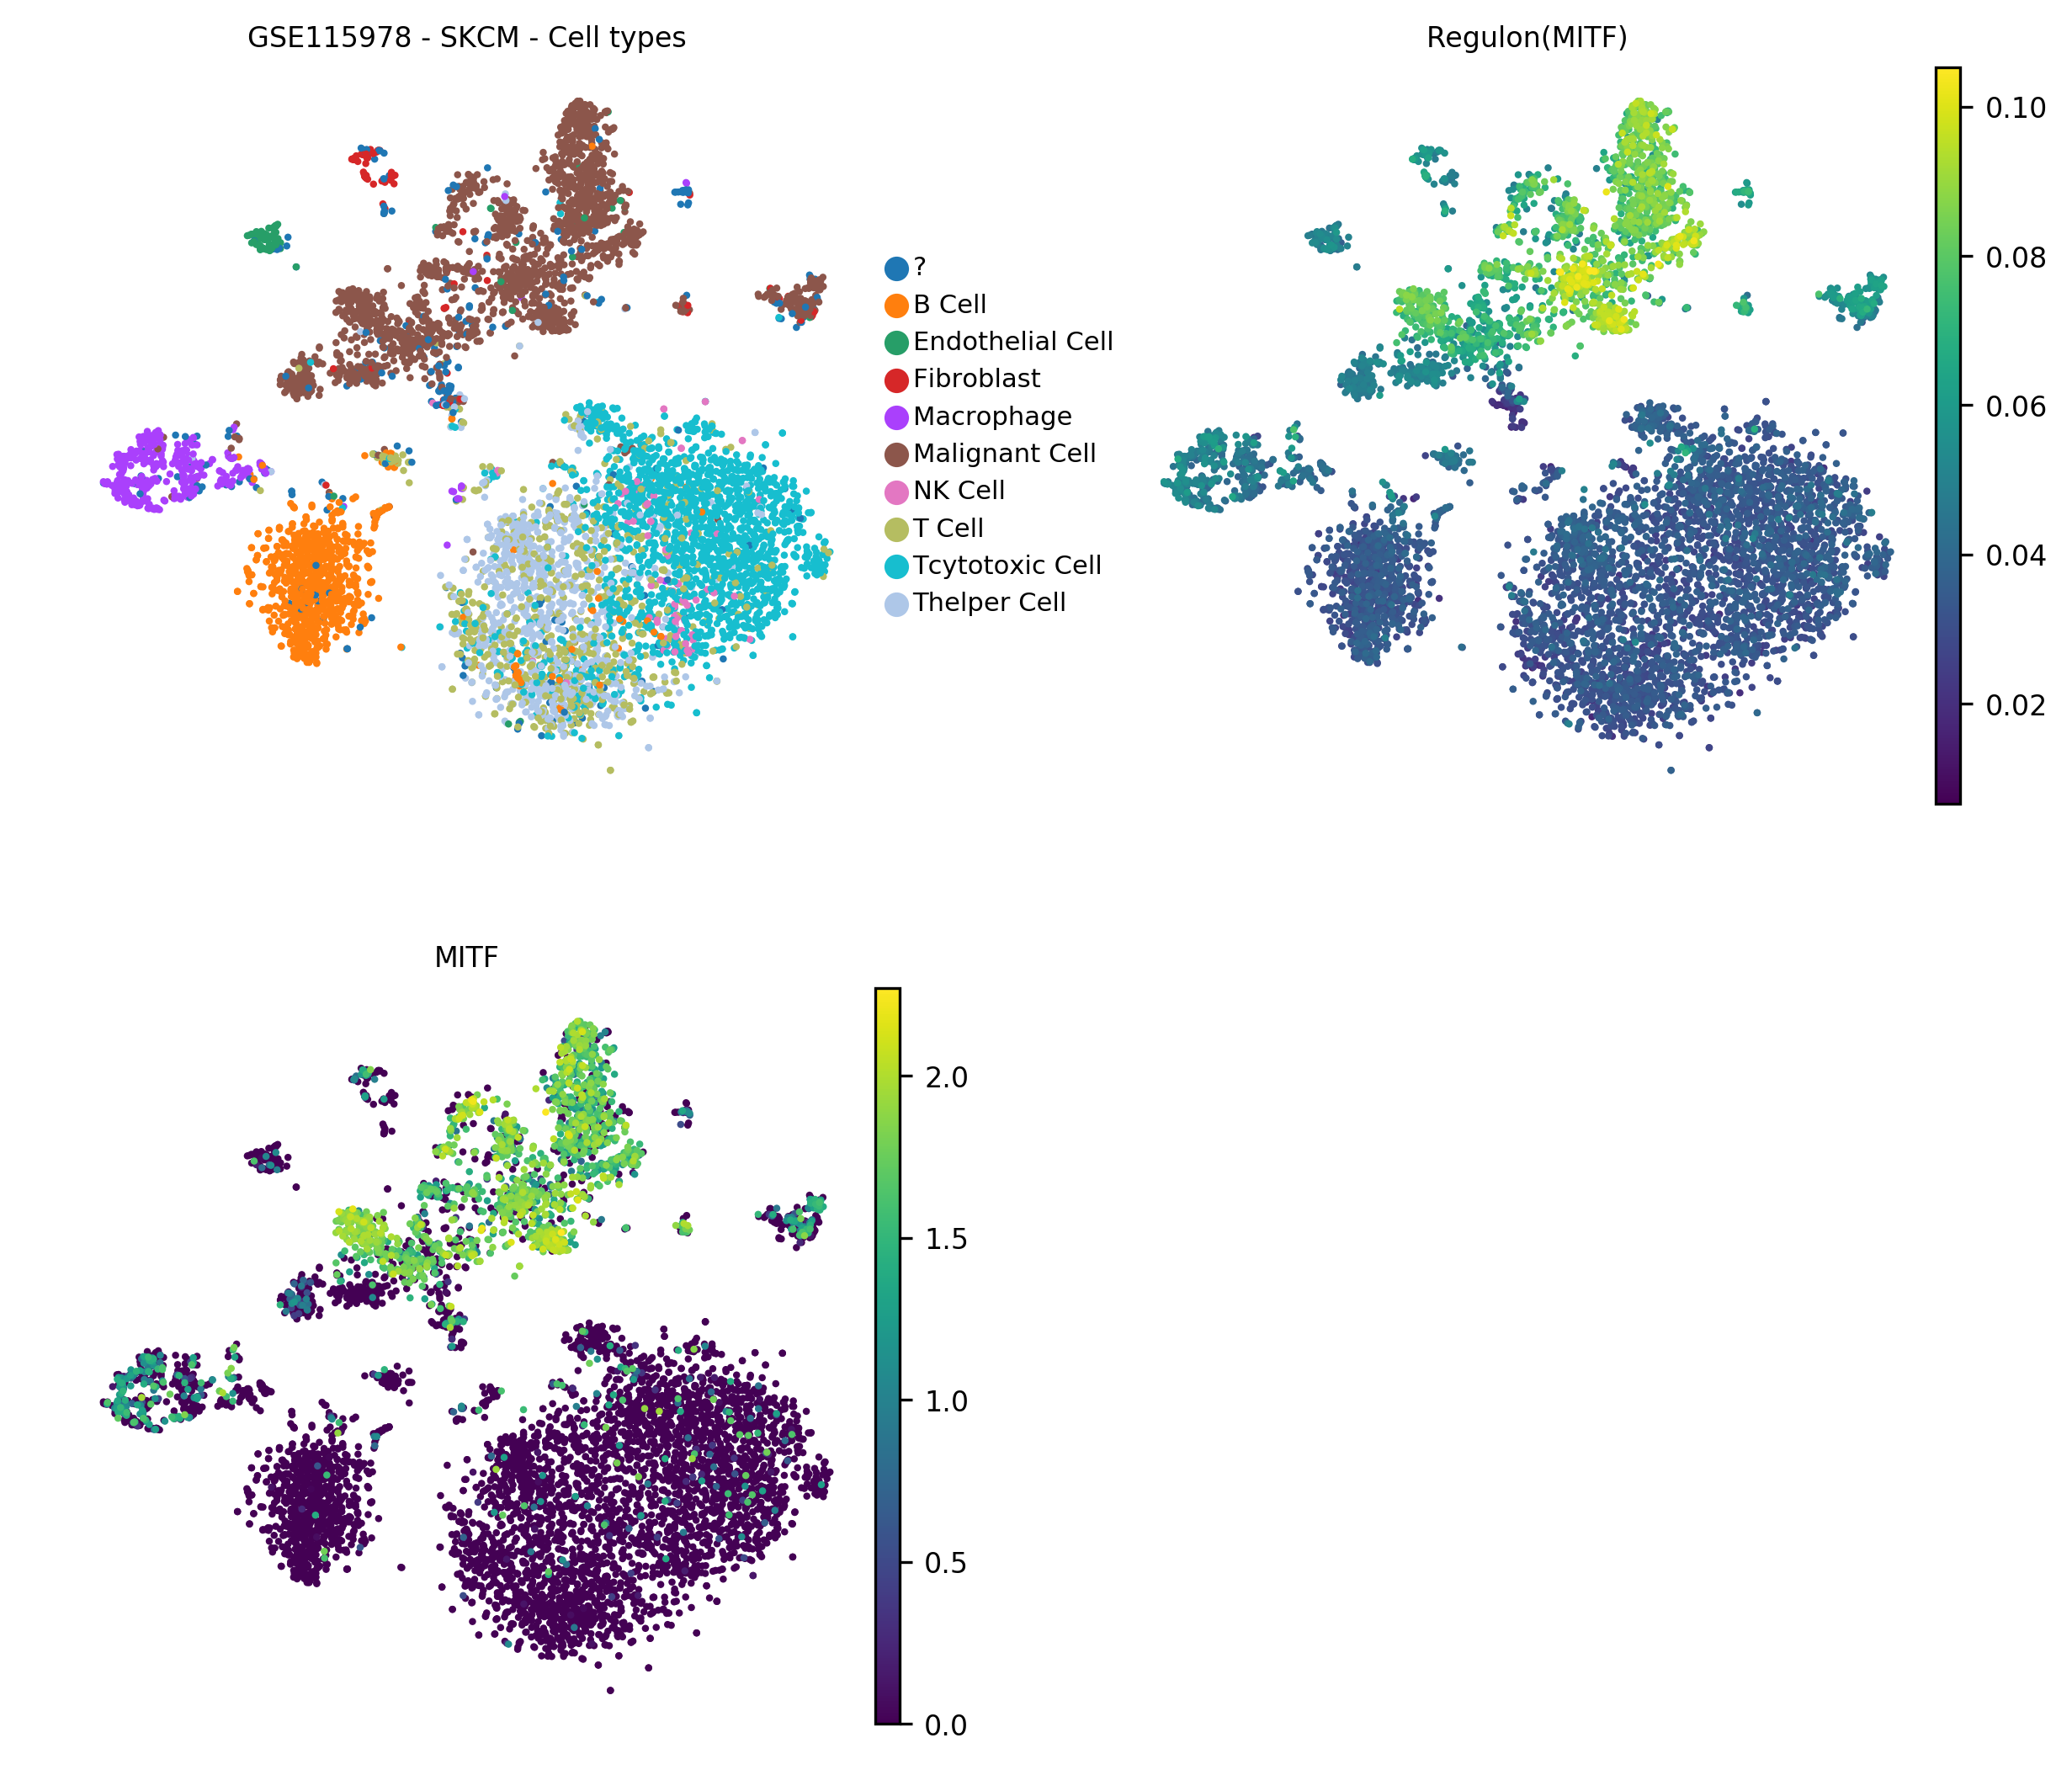

In [58]:
sc.pl.tsne(adata, color=['cell_type', 'Regulon(MITF)', 'MITF'], 
           title=['GSE115978 - SKCM - Cell types', 'Regulon(MITF)', 'MITF'], ncols=2, use_raw=False)

In [63]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = df_obs

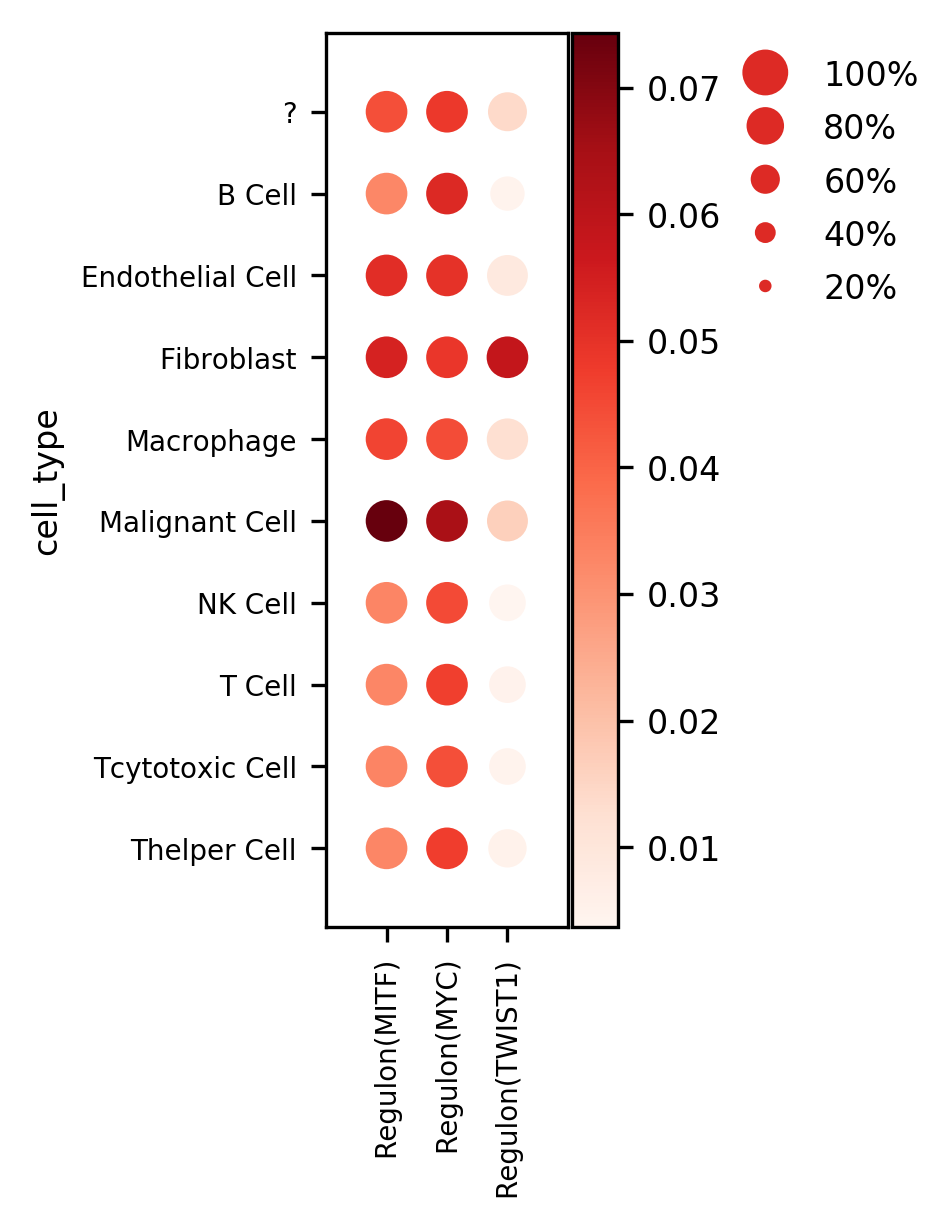

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[1.0499999999999998, 0, 0.2, 0.5, 0.25])

In [65]:
sc.pl.dotplot(aucell_adata, ['MITF', 'MYC', 'TWIST1'], groupby='cell_type')